In [1]:
# Define the 3 states
leave=0; drink=1; explore=2 # the 3 modes

In [6]:
from parameters import RewNames, UnrewNamesSub, OUTDATA_PATH
from MM_Traj_Utils import NewMaze, LoadTraj, LoadTrajFromPath, SplitModeClips, NewNodes4
import numpy as np
import pickle

In [11]:
import matplotlib.pyplot as plt

In [7]:
ma = NewMaze(6)

In [15]:
# Mode analysis for all animals
Names=RewNames+UnrewNamesSub
k=len(RewNames)
for i,nickname in enumerate(Names):
    tf=LoadTrajFromPath(OUTDATA_PATH + nickname+'-tf')
    cl0=SplitModeClips(tf,ma,re=i<k) # find the clips; no drink mode for unrewarded animals

    #### ONLY FIRST HALF
    cn=np.cumsum(cl0[:,2]) # cumulative number of nodes
    ha=np.where(cn>cn[-1]/2)[0][0] # index for half the number of nodes
    cl1=cl0[:ha];cl2=cl0[ha:] # two clip arrays for first and second half of nodes
    cl = cl1
    ####

    ti=np.array([tf.no[c[0]][c[1]+c[2],1]-tf.no[c[0]][c[1],1] for c in cl]) # duration in frames of each clip
    nn=np.array([np.sum(cl[np.where(cl[:,3]==leave)][:,2]),
                 np.sum(cl[np.where(cl[:,3]==drink)][:,2]),
                 np.sum(cl[np.where(cl[:,3]==explore)][:,2])]) # number of node steps in each mode
    nf=np.array([np.sum(ti[np.where(cl[:,3]==leave)]),
                 np.sum(ti[np.where(cl[:,3]==drink)]),
                 np.sum(ti[np.where(cl[:,3]==explore)])]) # number of frames in each mode
    tr=np.zeros((3,3)) # number of transitions between the 3 modes
    for i in range(1,len(cl)):
        tr[cl[i-1,3],cl[i,3]]+=1
    ce=cl[np.where(cl[:,3]==explore)] # clips of exploration
    ne=np.concatenate([tf.no[c[0]][c[1]:c[1]+c[2],0] for c in ce]) # nodes excluding the last state in each clip
    le=6 # end nodes only
    ln=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    ns=ne[np.isin(ne,ln)] # restricted to desired nodes
    wcn=NewNodes4(ns,nf[2]/len(ns)) # compute new nodes vs all nodes for exploration mode only
    with open(OUTDATA_PATH+nickname+'-Modes1', 'wb') as f: # save in one file per animal
        pickle.dump((nn,nf,tr,wcn),f)

Occupancy and transitions between modes

In [16]:
# Combine all the mode statistics from all animals into arrays
Names=RewNames+UnrewNamesSub
k=len(RewNames)
a=len(Names)
nn=np.zeros((a,3)) # number of nodes in each mode
nf=np.zeros((a,3)) # number of frames in each mode
tr=np.zeros((a,3,3)) # number of transitions between modes
ff=np.zeros((a,3)) # fraction of frames in each mode
wcn=[] # these arrays have different shape
for i,nickname in enumerate(Names):
    with open(OUTDATA_PATH+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn1=pickle.load(f)
    nn[i]=nn1
    nf[i]=nf1
    tr[i]=tr1
    wcn+=[wcn1]
    s=sum(nf[i])
    ff[i]=nf[i]/s

In [17]:
# List fraction of time in each mode
print('Fraction of frames in each mode')
print('     home | drink | explore')
print('rewarded:')
for i in range(k):
    print(Names[i]+': {:4.3f} | {:4.3f} | {:4.3f}'.format(*ff[i]))
print('------------------------')
print('Av: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.mean(ff[:k],axis=0)))
print('SD: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.std(ff[:k],axis=0)))
print('\nunrewarded:')
for i in range(k,len(Names)):
    print(Names[i]+': {:4.3f} | {:4.3f} | {:4.3f}'.format(*ff[i]))
print('------------------------')
print('Av: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.mean(ff[k:],axis=0)))
print('SD: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.std(ff[k:],axis=0)))

Fraction of frames in each mode
     home | drink | explore
rewarded:
B1: 0.037 | 0.052 | 0.910
B2: 0.040 | 0.054 | 0.906
B3: 0.029 | 0.051 | 0.920
B4: 0.044 | 0.073 | 0.883
C1: 0.038 | 0.076 | 0.886
C3: 0.078 | 0.094 | 0.828
C6: 0.025 | 0.039 | 0.936
C7: 0.028 | 0.063 | 0.909
C8: 0.028 | 0.081 | 0.891
C9: 0.027 | 0.092 | 0.881
------------------------
Av: 0.037 | 0.068 | 0.895
SD: 0.015 | 0.018 | 0.028

unrewarded:
B5: 0.066 | 0.000 | 0.934
B6: 0.036 | 0.000 | 0.964
B7: 0.054 | 0.000 | 0.946
D3: 0.040 | 0.000 | 0.960
D4: 0.031 | 0.000 | 0.969
D5: 0.041 | 0.000 | 0.959
D7: 0.038 | 0.000 | 0.962
D8: 0.026 | 0.000 | 0.974
D9: 0.029 | 0.000 | 0.971
------------------------
Av: 0.040 | 0.000 | 0.960
SD: 0.012 | 0.000 | 0.012


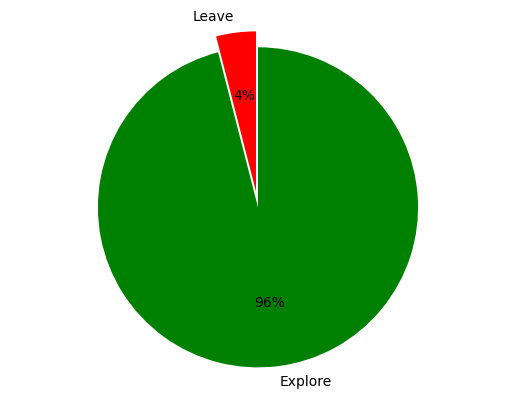

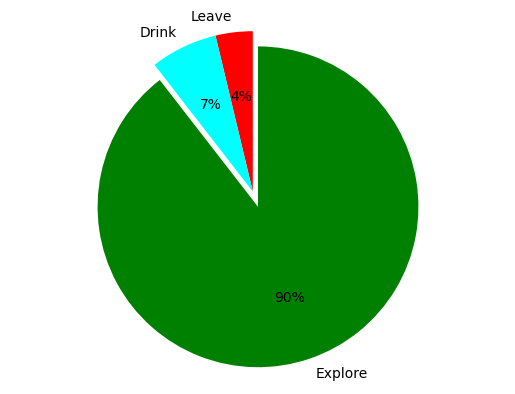

In [18]:
# Pie charts, where the slices will be ordered and plotted counter-clockwise:
labels = 'Leave','Explore'
av=np.mean(ff[k:],axis=0)
sizes = [av[0],av[2]]
explode = (0,0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90,colors=['red','green'])
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
#         shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('figs/UnrewPie.pdf')
plt.show()

labels = 'Leave','Drink','Explore'
av=np.mean(ff[:k],axis=0)
sizes = [av[0],av[1],av[2]]
explode = (0,0,0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90,colors=['red','cyan','green'])
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
#         shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('figs/RewPie.pdf')
plt.show()

In [19]:
# transitions between modes
print('Prob of transition between leave, drink, explore:')
print('     l->d  | l->e  | d->l  | d->e  | e->h  | e->d')
n=[]
for i,nickname in enumerate(RewNames):
    s=tr[i,0,1]+tr[i,0,2] # ignore the h->h transition
    nn=tr[i,0,1:]/s
    s=tr[i,1,0]+tr[i,1,2]
    nn=np.append(nn,[tr[i,1,0]/s,tr[i,1,2]/s])
    s=tr[i,2,0]+tr[i,2,1]
    nn=np.append(nn,[tr[i,2,0]/s,tr[i,2,1]/s])
    n+=[nn]
    print(nickname,': {:4.3f} | {:4.3f}'.format(nn[0],nn[1]),end='')
    print(' | {:4.3f} | {:4.3f}'.format(nn[2],nn[3]),end='')
    print(' | {:4.3f} | {:4.3f}'.format(nn[4],nn[5]))
n=np.array(n)
av=np.mean(n,axis=0)
sd=np.std(n,axis=0)
print('----------------------------------------------')
print('Av : {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f}'.format(*av))
print('SD : {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f}'.format(*sd))

Prob of transition between leave, drink, explore:
     l->d  | l->e  | d->l  | d->e  | e->h  | e->d
B1 : 0.143 | 0.857 | 0.000 | 1.000 | 0.370 | 0.630
B2 : 0.130 | 0.870 | 0.043 | 0.957 | 0.323 | 0.677
B3 : 0.091 | 0.909 | 0.000 | 1.000 | 0.535 | 0.465
B4 : 0.237 | 0.762 | 0.033 | 0.967 | 0.362 | 0.638
C1 : 0.470 | 0.530 | 0.111 | 0.889 | 0.377 | 0.623
C3 : 0.460 | 0.540 | 0.172 | 0.828 | 0.453 | 0.547
C6 : 0.034 | 0.966 | 0.000 | 1.000 | 0.333 | 0.667
C7 : 0.191 | 0.809 | 0.010 | 0.990 | 0.329 | 0.671
C8 : 0.609 | 0.391 | 0.039 | 0.961 | 0.399 | 0.601
C9 : 0.375 | 0.625 | 0.060 | 0.940 | 0.203 | 0.797
----------------------------------------------
Av : 0.274 | 0.726 | 0.047 | 0.953 | 0.368 | 0.632
SD : 0.182 | 0.182 | 0.053 | 0.053 | 0.083 | 0.083


In [20]:
# markdown table of transition probabilities
print('|from / to:   | leave | drink | explore |')
print('|:--|:-:|:-:|:-:|')
print('|**leave**|   |{:3.2f} ± {:3.2f}|{:3.2f} ± {:3.2f}|'.format(av[0],sd[0],av[1],sd[1]))
print('|**drink**|{:3.2f} ± {:3.2f}|  |{:3.2f} ± {:3.2f}|'.format(av[2],sd[2],av[3],sd[3]))
print('|**explore**|{:3.2f} ± {:3.2f}|{:3.2f} ± {:3.2f}|   |'.format(av[4],sd[4],av[5],sd[5]))

|from / to:   | leave | drink | explore |
|:--|:-:|:-:|:-:|
|**leave**|   |0.27 ± 0.18|0.73 ± 0.18|
|**drink**|0.05 ± 0.05|  |0.95 ± 0.05|
|**explore**|0.37 ± 0.08|0.63 ± 0.08|   |


ALL Night:

|from / to:   | leave | drink | explore |
|:--|:-:|:-:|:-:|
|**leave**|   |0.51 ± 0.14|0.49 ± 0.14|
|**drink**|0.10 ± 0.05|  |0.90 ± 0.05|
|**explore**|0.40 ± 0.11|0.60 ± 0.11|   |

First HALF:

|from / to:   | leave | drink | explore |
|:--|:-:|:-:|:-:|
|**leave**|   |0.27 ± 0.18|0.73 ± 0.18|
|**drink**|0.05 ± 0.05|  |0.95 ± 0.05|
|**explore**|0.37 ± 0.08|0.63 ± 0.08|   |